# Traffic Sign Classifier


### Step 0: Load The Data

In [227]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file =  'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('Data Loaded')

Data Loaded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Summary of Data 

In [112]:
import numpy as np

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:3]
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Plot Random Images From Training Set

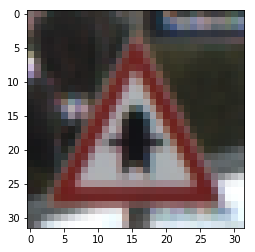

In [231]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

#Plot images from the features set
image_num = random.randint(0,n_train)
image = X_train[image_num]
if(len(image.shape) > 2):
    imgplot = plt.imshow(image)
else:
    imgplot = plt.imshow(image,cmap='gray')

### Pre-process the Data Set 

In [114]:
def rgb2gray(images):
    
    r, g, b = images[:,:,:,0], images[:,:,:,1], images[:,:,:,2]
    gray = 0.2126 * r + 0.7152* g + 0.0722 * b
    return gray

#Convert to grayscale and reshape
if(len(X_train.shape) > 3):
    X_train = np.reshape(rgb2gray(X_train),(n_train,32,32,1))
    X_valid = np.reshape(rgb2gray(X_valid),(n_validation,32,32,1))
    X_test = np.reshape(rgb2gray(X_test),(n_test,32,32,1))


    
print("Images converted to grayscale")

Images converted to grayscale


### Model Architecture

In [115]:
#Example architecture
from tensorflow.contrib.layers import flatten

def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.01
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x10.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 10), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x10. Output = 14x14x10.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Dropout
    conv1 = tf.nn.dropout(conv1,keep_prob)
    
    # Layer 2: Convolutional Input = 14x14x10 Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 10, 24), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(24))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x24. Output = 5x5x24.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Dropout
    conv2 = tf.nn.dropout(conv2,keep_prob)
    
    # Flatten. Input = 5x5x16. Output = 600.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 600. Output = 240.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(600, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 240. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Build the Model

In [116]:
#Model
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32,shape=(None,32,32,1))
logits=LeNet(x,keep_prob)

y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y,43)


# Calculate the loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
loss = tf.reduce_mean(cross_entropy)

#Set up the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

print("Model Built")

Model Built


### Model Evaluation

In [276]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
prediction = tf.argmax(logits,1)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

softmax_logits = tf.nn.softmax(logits)
top_k_values = tf.nn.top_k(softmax_logits,k=5)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [119]:
from sklearn.utils import shuffle

#Training Parameters
learning_rate = 0.0001
EPOCHS = 100
BATCH_SIZE = 128
KEEP_PROB = 0.65

with tf.Session() as sess:
    #Initiate variables
    init = tf.global_variables_initializer()
    sess.run(init)
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_op, feed_dict={x: batch_x, y: batch_y,keep_prob:KEEP_PROB})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
        

Training...

EPOCH 1 ...
Validation Accuracy = 0.486

EPOCH 2 ...
Validation Accuracy = 0.795

EPOCH 3 ...
Validation Accuracy = 0.847

EPOCH 4 ...
Validation Accuracy = 0.881

EPOCH 5 ...
Validation Accuracy = 0.913

EPOCH 6 ...
Validation Accuracy = 0.885

EPOCH 7 ...
Validation Accuracy = 0.912

EPOCH 8 ...
Validation Accuracy = 0.907

EPOCH 9 ...
Validation Accuracy = 0.937

EPOCH 10 ...
Validation Accuracy = 0.933

EPOCH 11 ...
Validation Accuracy = 0.927

EPOCH 12 ...
Validation Accuracy = 0.938

EPOCH 13 ...
Validation Accuracy = 0.934

EPOCH 14 ...
Validation Accuracy = 0.931

EPOCH 15 ...
Validation Accuracy = 0.943

EPOCH 16 ...
Validation Accuracy = 0.928

EPOCH 17 ...
Validation Accuracy = 0.940

EPOCH 18 ...
Validation Accuracy = 0.937

EPOCH 19 ...
Validation Accuracy = 0.939

EPOCH 20 ...
Validation Accuracy = 0.937

EPOCH 21 ...
Validation Accuracy = 0.941

EPOCH 22 ...
Validation Accuracy = 0.941

EPOCH 23 ...
Validation Accuracy = 0.936

EPOCH 24 ...
Validation Accura

## Step 3: Test Model on Images from the Internet


### Load and Output the Images

(1, 32, 32, 3)
(1, 32, 32, 3)
(1, 32, 32, 3)
(1, 32, 32, 3)
(1, 32, 32, 3)


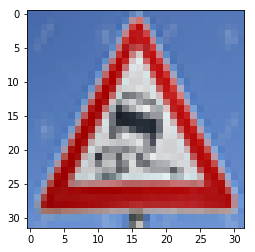

In [263]:
import matplotlib.image as mpimg
from PIL import Image
from scipy import ndimage

size = [32,32]
images = []
y_internet = np.array([23,14,1,13,25])

for i in range(1,6):
    img_loc = 'germansigns/sign' + str(i) + '.jpg'
    img = Image.open(img_loc)
    img = img.resize(size,Image.ANTIALIAS)
    img = np.array(img)
    img = np.resize(img,(1,32,32,3))
    
    images.append(img)
    print(img.shape)

X_internet = np.vstack(images)

#Plot image
image = X_internet[0]
imgplot = plt.imshow(image)

#Convert to grayscale
X_internet = np.resize(rgb2gray(X_internet),(X_internet.shape[0],32,32,1))


### Predict the Sign Type for Each Image

In [267]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    
    prediction = sess.run(prediction, feed_dict={x: X_internet, y: y_internet,keep_prob: 1.0})
    print("Prediction is " + str(prediction))
    
    validation_accuracy = evaluate(X_internet, y_internet)
    print("Accuracy is " + str(validation_accuracy))
    

INFO:tensorflow:Restoring parameters from ./lenet
Accuracy is 1.0
Prediction is [23 14  1 13 25]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [281]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    softmax = sess.run(top_k_values,feed_dict={x: X_internet, y: y_internet,keep_prob: 1.0})
    print("Top Softmax are: ")
    np.set_printoptions(suppress=True)
    print(softmax[0])

INFO:tensorflow:Restoring parameters from ./lenet
Top Softmax are: 
[[ 1.     0.     0.     0.     0.   ]
 [ 0.998  0.002  0.     0.     0.   ]
 [ 1.     0.     0.     0.     0.   ]
 [ 1.     0.     0.     0.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [13]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")